# Basic usage of the package

### Loading files

The `load_from_csv()` function provides a relief of dealing with numerous files. It can load a single CSV file, but it can also scan a directory and load all files in that directory and returns a `Dataset` object. While appending new `Timeseries` to the `Dataset`, it makes sure that timeseries from the same locations and sensors are merged together. It is important to note, that the timeseries should be an uninterupted series of measurements.

*Example:*

*In Project Grow, we had absolute pressure transducers deployed across an agricultural field. We obtained all measurements for sensor altitude necessary for converting the raw measurments to groundwater levels in meters above sea level. However, over time, some piezometers had to be shortened, and the sensors were re-deployed at the same location with the same cable. Hence, we had to split the timeseries into pieces to account for chaning sensor altitude.The loggers we use in Project Grow record temerature and pressure, but there are also other products that can measure electricul conductivity as well. In the CSV file each timeseries is saved in a separate column. `load_from_csv()` function splits the columns into individual timeseries and creates a list of `Timeseries` objects.*

*Note: In the vanessen file, the metadata of the diver and the station it is deployed to is stored in the header of the file. To extract those from all the files, I used regex. It is important that the user knows the naming patterns of the stations and replace the default pattern using a kwarg `location_pattern`. It is possible to add an OR (|) operator to try matching multiple patterns. For us, the following pattern matches all substrings that start with two letters, have two numbers in the middle and end with one letter or include a string 'Barodived' `pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'`*

In [1]:
from gensor.data import files

## Explore the Timeseries

In [3]:
from gensor import read_from_csv

pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'

data = read_from_csv(path=files, 
                    file_format='vanessen', 
                    location_pattern=pattern)


Loading file: /workspaces/gensor/gensor/data/Barodiver_220427183008_BY222.csv
Loading file: /workspaces/gensor/gensor/data/PB01A_moni_AV319_220427183019_AV319.csv


In [18]:
data

Dataset(4)

## Compensation

To compensate the measurements from an absolute pressure sensor for atmospheric pressure we need to do two things:
- Identify the atmospheric pressure timeseries
- Include the sensor elevation in the submerged sensor timeseries

In [5]:
# identify the barometric timeseries in your dataset
baro = data.filter(station='Barodiver', variable='pressure')
baro

Timeseries(variable='pressure', unit='cmh2o', location='Barodiver', sensor='BY222', sensor_alt=None, start=Timestamp('2020-07-04 04:00:00+0000', tz='UTC'), end=Timestamp('2022-03-30 13:00:00+0000', tz='UTC'))

In [8]:
# Adding extra information to the submerged sensor timeseries
pb01a = data.filter(station='PB01A', variable='pressure')
pb01a

Timeseries(variable='pressure', unit='cmh2o', location='PB01A', sensor='AV319', sensor_alt=None, start=Timestamp('2020-07-04 04:00:00+0000', tz='UTC'), end=Timestamp('2022-03-30 09:00:00+0000', tz='UTC'))

In [9]:
pb01a.sensor_alt = 33.36

In [13]:
from gensor import compensate

pb01a_comp = compensate(pb01a, baro, drop_low_wc=False)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Head at PB01A'}, xlabel='Time', ylabel='head (m asl)'>)

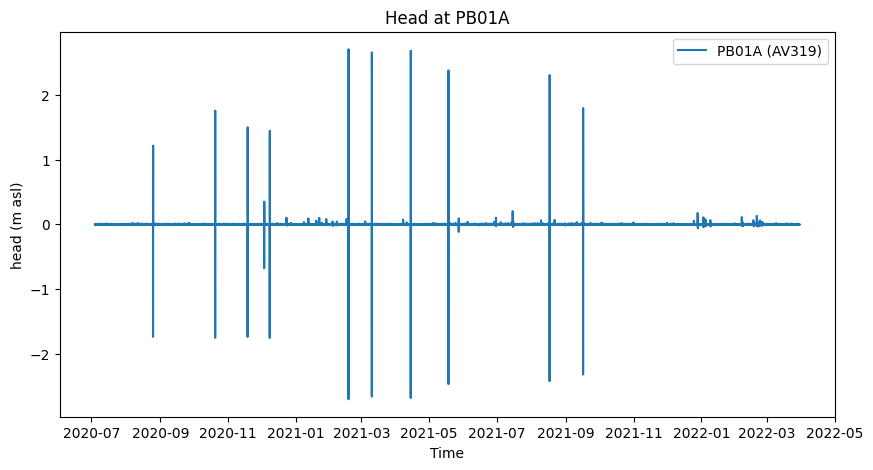

In [14]:
pb01a_comp.transform("difference").plot()

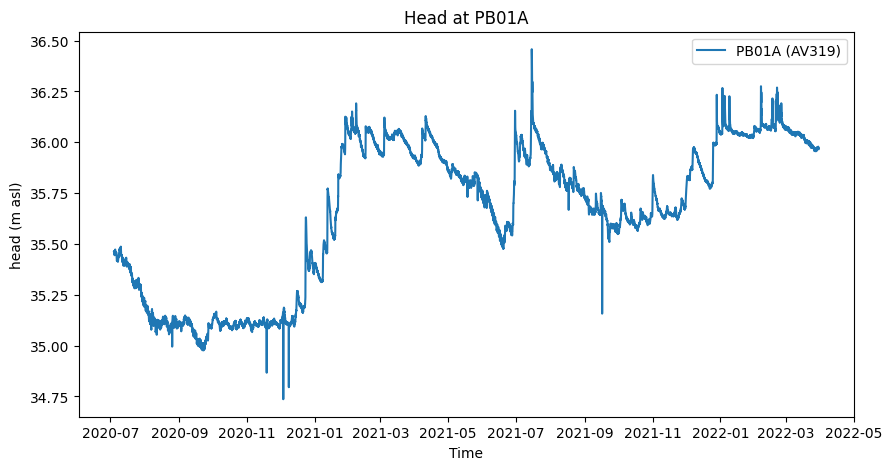

In [17]:
fig, ax = pb01a_comp.detect_outliers("zscore").plot()
